# **Generar mappings de ingredientes 🧴**

Los productos scrapeados tienen listas de ingredientes, pero están escritos de forma muy inconsistente. Por ejemplo:
- La separación entre ingredientes a veces es con ",", otras veces es con "+", y etc.
- Un mismo ingrediente puede ser llamado de muchas maneras:

    &nbsp;&nbsp;&nbsp;&nbsp;Dióxido de titanio puede ser "CI 77891", o "dióxido de titanio" o "titanium dioxide", etc.
    
- Los ingredientes pueden venir con una descripción, que no es relevante si sólo nos interesa el nombre del ingrediente:

    &nbsp;&nbsp;&nbsp;&nbsp;En lugar de "neurosensina", ponen "neurosensina que calma las pieles sensibles" 

Ya que hay muchas formas de representar un mismo ingrediente, vamos a generar un mapping en donde varios nombres de un ingrediente tengan asignado un sólo nombre limpio y consistente. Por ejemplo

- dióxido de titanio: **dióxido de titanio**
- ci 77891: **dióxido de titanio**
- titanium dioxide: **dióxido de titanio**
- dióxido de titanio para coloración blanca: **dióxido de titanio**

In [1]:
import pandas as pd
import re
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import csv
import shutil
import json

# send to deepseek...
import requests
import json
from time import sleep

In [2]:
# Leer dataframes de inkafarma y mifarma
df = pd.read_csv("../scraping/data/inkafarma-raw.csv")
mif = pd.read_csv("../scraping/data/mifarma-raw.csv")

# concatenate mifarma and inkafarma dataframes, ya que tienen los mismos atributos
df = pd.concat([df, mif], ignore_index=True)
df.head()

,title,price,info,composition,usage,precautions,brand,image,description,url
0,Fotoprotector Isdin Fusión Water Pediatrics SPF50,S/ 124.90,"['Todo tipo de piel, incluso piel atópica y/o ...","Vitamina E, provitamina B5 y extracto de siemp...",Aplica Fusion Water MAGIC Pediatrics SPF 50 ge...,Uso externo. Mantener el producto fuera del al...,ISDIN,https://dcuk1cxrnzjkh.cloudfront.net/imagespro...,Fotoprotector Isdin Fusión Water Pediatrics SP...,https://inkafarma.pe/producto/fotoprotector-is...
1,Crema Anti-irritación La Roche Posay Lipikar 4...,S/ 176.90,"['Calma la piel inmediatamente.', 'Con su efic...",Aqua Posae Filiformis + Microresyl: Devuelve e...,Aplicar sobre la piel limpia con masaje circul...,Mantener fuera del alcance de los niños.,LA ROCHE-POSAY,https://dcuk1cxrnzjkh.cloudfront.net/imagespro...,Crema Anti-irritación La Roche Posay Lipikar B...,https://inkafarma.pe/producto/lipikar-baume-ap...
2,Serum Isdinceutics Retinal Intense,S/ 299.90,"['Ayuda a acelerar la renovación cutánea', 'Re...","Aqua (Water), Dimethicone, Dibutyl Adipate, Ni...",Aplica Retinal Intense en tu rutina de noche. ...,"Si es la primera vez que usas un retinoide, te...",ISDIN,https://dcuk1cxrnzjkh.cloudfront.net/imagespro...,Serum Isdinceutics Retinal Intense. El retinal...,https://inkafarma.pe/producto/serum-isdinceuti...
3,Crema en Gel Hidratante CeraVe Control de Grasa,S/ 60.90,"['Tecnología de control de grasa', 'No deja la...","AGUA, NIACINAMIDA, GLICERINA, ISONONANOATO DE ...",Aplicar generosamente sobre el rostro y el cue...,"Uso para adolescentes, jóvenes y adultos. En c...",CERAVE,https://dcuk1cxrnzjkh.cloudfront.net/imagespro...,Crema en Gel Hidratante CeraVe Control de Gras...,https://inkafarma.pe/producto/crema-en-gel-hid...
4,Gel de Limpieza Bioderma Moussant Sebium 200ml,S/ 152.90,"['Cuidado de la Piel.', 'NSOC15273-13PE']",NaN,NaN,Evitar el contacto directo con los ojos.,BIODERMA,https://dcuk1cxrnzjkh.cloudfront.net/imagespro...,Gel de limpieza Bioderma Moussant Sebium para ...,https://inkafarma.pe/producto/gel-purificante-...


In [3]:
# lower text columns
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].str.lower()

# keep only those rows that have a composition (INGREDIENTS).
df_filtered = df[df.composition.notna()]

# drop shampoos and hair products
df_filtered = df_filtered[~df_filtered['title'].str.contains('shampoo|champú|anticaída|pack', flags=re.IGNORECASE, na=False)]
print(len(df_filtered))
df_filtered.head()

148


,title,price,info,composition,usage,precautions,brand,image,description,url
0,fotoprotector isdin fusión water pediatrics spf50,s/ 124.90,"['todo tipo de piel, incluso piel atópica y/o ...","vitamina e, provitamina b5 y extracto de siemp...",aplica fusion water magic pediatrics spf 50 ge...,uso externo. mantener el producto fuera del al...,isdin,https://dcuk1cxrnzjkh.cloudfront.net/imagespro...,fotoprotector isdin fusión water pediatrics sp...,https://inkafarma.pe/producto/fotoprotector-is...
1,crema anti-irritación la roche posay lipikar 4...,s/ 176.90,"['calma la piel inmediatamente.', 'con su efic...",aqua posae filiformis + microresyl: devuelve e...,aplicar sobre la piel limpia con masaje circul...,mantener fuera del alcance de los niños.,la roche-posay,https://dcuk1cxrnzjkh.cloudfront.net/imagespro...,crema anti-irritación la roche posay lipikar b...,https://inkafarma.pe/producto/lipikar-baume-ap...
2,serum isdinceutics retinal intense,s/ 299.90,"['ayuda a acelerar la renovación cutánea', 're...","aqua (water), dimethicone, dibutyl adipate, ni...",aplica retinal intense en tu rutina de noche. ...,"si es la primera vez que usas un retinoide, te...",isdin,https://dcuk1cxrnzjkh.cloudfront.net/imagespro...,serum isdinceutics retinal intense. el retinal...,https://inkafarma.pe/producto/serum-isdinceuti...
3,crema en gel hidratante cerave control de grasa,s/ 60.90,"['tecnología de control de grasa', 'no deja la...","agua, niacinamida, glicerina, isononanoato de ...",aplicar generosamente sobre el rostro y el cue...,"uso para adolescentes, jóvenes y adultos. en c...",cerave,https://dcuk1cxrnzjkh.cloudfront.net/imagespro...,crema en gel hidratante cerave control de gras...,https://inkafarma.pe/producto/crema-en-gel-hid...
5,fotoprotector bioderma pediatrics lait,s/ 154.90,"['muy alta protección y multi-resistente.', 'p...",protege y refuerza la delicada piel de los niñ...,aplicar sólo sobre piel sana. niños mayores de...,uso especializado para bebés a partir de 12 me...,bioderma,https://dcuk1cxrnzjkh.cloudfront.net/imagespro...,fotoprotector photoderm bioderma pediatrics la...,https://inkafarma.pe/producto/fotoprotector-ph...


### categorías LTP 🧼🧴🛡️

Trabajamos con 3 categorías generales de productos, según su función: Limpieza (L), Tratamiento (T), Protección (P).
Asignamos un marcador de LTP basados en el nombre del producto

In [4]:
limpiar = [
    'cleanser', 'exfolia', 'jabón', 'oil', 'aceite', 
    'glicolic', 'higiene', 'syndet', 'micelar', 'limpia',
    'gel moussant', 'ducha', 'purifica'
]

tratar = [
    'tratamiento', 'serum', 'sérum', 'serúm', 'ampolla', 
    'crema ojos', 'ojos', 'retinol', 'pigment', 'repara', 
    'mancha', 'estría', 'rugosidad', 'imperfeccion', 
    'neotetrin', 'irrita', 'redness', 'hidrata', 'calma',
    'age absolu', 'hyaluron', 'hialuron'
]

proteger = [
    'fotoprotector', 'bloqueador', 'spf', 'bloqueador', 
    'concentrado fortificante', 'photo', 'anthelios',
    'protector'
]

limpiar_pattern = '|'.join(limpiar)
tratar_pattern = '|'.join(tratar)
proteger_pattern = '|'.join(proteger)

categorias = limpiar + tratar + proteger
pattern = '|'.join(categorias)
df_filtered[~df_filtered['title'].str.contains(pattern, flags=re.IGNORECASE, na=False)].title.to_csv('title_column.txt', index=False, header=False)

df_filtered['limpiar'] = df_filtered['title'].str.contains(limpiar_pattern, flags=re.IGNORECASE, na=False)
df_filtered['tratar'] = df_filtered['title'].str.contains(tratar_pattern, flags=re.IGNORECASE, na=False)
df_filtered['proteger'] = df_filtered['title'].str.contains(proteger_pattern, flags=re.IGNORECASE, na=False)

df_filtered.head()

,title,price,info,composition,usage,precautions,brand,image,description,url,limpiar,tratar,proteger
0,fotoprotector isdin fusión water pediatrics spf50,s/ 124.90,"['todo tipo de piel, incluso piel atópica y/o ...","vitamina e, provitamina b5 y extracto de siemp...",aplica fusion water magic pediatrics spf 50 ge...,uso externo. mantener el producto fuera del al...,isdin,https://dcuk1cxrnzjkh.cloudfront.net/imagespro...,fotoprotector isdin fusión water pediatrics sp...,https://inkafarma.pe/producto/fotoprotector-is...,False,False,True
1,crema anti-irritación la roche posay lipikar 4...,s/ 176.90,"['calma la piel inmediatamente.', 'con su efic...",aqua posae filiformis + microresyl: devuelve e...,aplicar sobre la piel limpia con masaje circul...,mantener fuera del alcance de los niños.,la roche-posay,https://dcuk1cxrnzjkh.cloudfront.net/imagespro...,crema anti-irritación la roche posay lipikar b...,https://inkafarma.pe/producto/lipikar-baume-ap...,False,True,False
2,serum isdinceutics retinal intense,s/ 299.90,"['ayuda a acelerar la renovación cutánea', 're...","aqua (water), dimethicone, dibutyl adipate, ni...",aplica retinal intense en tu rutina de noche. ...,"si es la primera vez que usas un retinoide, te...",isdin,https://dcuk1cxrnzjkh.cloudfront.net/imagespro...,serum isdinceutics retinal intense. el retinal...,https://inkafarma.pe/producto/serum-isdinceuti...,False,True,False
3,crema en gel hidratante cerave control de grasa,s/ 60.90,"['tecnología de control de grasa', 'no deja la...","agua, niacinamida, glicerina, isononanoato de ...",aplicar generosamente sobre el rostro y el cue...,"uso para adolescentes, jóvenes y adultos. en c...",cerave,https://dcuk1cxrnzjkh.cloudfront.net/imagespro...,crema en gel hidratante cerave control de gras...,https://inkafarma.pe/producto/crema-en-gel-hid...,False,True,False
5,fotoprotector bioderma pediatrics lait,s/ 154.90,"['muy alta protección y multi-resistente.', 'p...",protege y refuerza la delicada piel de los niñ...,aplicar sólo sobre piel sana. niños mayores de...,uso especializado para bebés a partir de 12 me...,bioderma,https://dcuk1cxrnzjkh.cloudfront.net/imagespro...,fotoprotector photoderm bioderma pediatrics la...,https://inkafarma.pe/producto/fotoprotector-ph...,False,False,True


In [5]:
# categorize remaining products manually, as their titles do not match the patterns
df_filtered.loc[df_filtered.title == 'la roche posay toleriane dermallergo fluido', 'tratar'] = True
df_filtered.loc[df_filtered['title'].str.contains('bálsamo la roche posay cicaplast baume', flags=re.IGNORECASE, na=False), 'tratar'] = True
df_filtered.loc[df_filtered.title == 'bálsamo la roche posay lipikar baume ap+m', 'tratar'] = True
df_filtered.loc[df_filtered['title'].str.contains('bálsamo la roche posay cicaplast baume', flags=re.IGNORECASE, na=False), 'tratar'] = True
df_filtered.loc[df_filtered['title'].str.contains('bálsamo para piel sensible eucerin', flags=re.IGNORECASE, na=False), 'tratar'] = True
df_filtered.loc[df_filtered['title'].str.contains('crema para piel sensible bioderma ', flags=re.IGNORECASE, na=False), 'tratar'] = True
df_filtered.loc[df_filtered['title'].str.contains('gel concentrado eucerin dermopure triple effect', flags=re.IGNORECASE, na=False), 'tratar'] = True
df_filtered.loc[df_filtered['title'].str.contains('gel concentrado eucerin dermopure triple effect', flags=re.IGNORECASE, na=False), 'limpiar'] = True

In [6]:
# quedaron sin categoría
df_filtered[~(df_filtered.limpiar | df_filtered.tratar | df_filtered.proteger)]

,title,price,info,composition,usage,precautions,brand,image,description,url,limpiar,tratar,proteger
41,bb blur effaclar la roche posay anti brillo 30ml,s/ 119.90,"['cubre imperfecciones.', 'controla el exceso ...",bb pigmentos: oculta manchas e imperfecciones....,"aplicar sobre la piel día, noche y retocar cua...",mantener fuera del alcance de los niños.,la roche-posay,https://dcuk1cxrnzjkh.cloudfront.net/imagespro...,bb blur unificador effaclar la roche posay ant...,https://inkafarma.pe/producto/effaclar-bb-blur...,False,False,False
235,gel creme bioderma atoderm intensive 500ml,s/ 163.90,"['nutrición de la piel', 'antipicor y ultra fr...","water (aqua), glycerin, niacinamide, sodium po...",usar el producto de la siguiente manera:,exceptuar uso en prematuros. si la sequedad de...,bioderma,https://dcuk1cxrnzjkh.cloudfront.net/imagespro...,gel creme bioderma atoderm intensive te brinda...,https://inkafarma.pe/producto/gel-creme-bioder...,False,False,False
254,gel dermatológico uriage para rostro y cuerpo,s/ 104.90,"['gel frescos', 'limpia la piel', 'ultrasuave'...","agua termal de uriage, agentes hidratantes, ag...",NaN,evitar el contacto con los ojos,uriage,https://dcuk1cxrnzjkh.cloudfront.net/imagespro...,NaN,https://www.mifarma.com.pe/producto/gel-dermat...,False,False,False


## Limpieza de ingredientes

In [7]:
# Replace "\n" with ", " and remove hidden characters
df_filtered['composition'] = (
    df_filtered['composition']
    .str.replace("\n", ", ", regex=False)  # Replace newline characters
    .str.strip()  # Remove leading and trailing whitespace
)

### Separaciones de ingredientes
Son diferentes.

In [8]:
# algunos ingredientes están separados por " -", reemplazar por ", "
df_filtered.loc[df_filtered['composition'].str.count(' -') >= 2, 'composition'] = df_filtered['composition'].str.replace(' -', ',', regex=False)
df_filtered['composition'] = df_filtered['composition'].str.strip('.')

# algunos ingredientes están separados por " /", reemplazar por ", "
df_filtered.loc[df_filtered['composition'].str.count(' /') >= 2, 'composition'] = df_filtered['composition'].str.replace(' /', ',', regex=False)
df_filtered['composition'] = df_filtered['composition'].str.strip('.')

# algunos ingredientes están separados por " y ", reemplazar por ", "
df_filtered['composition'] = df_filtered['composition'].str.replace(r' y ', ', ', regex=True)

# Otros ingredientes están separados por "(and)"
df_filtered['composition'] = df_filtered['composition'].str.replace(r'\(and\)', ',', regex=True)

# y otros están separados por "+"
df_filtered['composition'] = df_filtered['composition'].str.replace(r'\+', ',', regex=True)

# y oootros están separados con puntos "."
df_filtered['composition'] = df_filtered['composition'].str.replace(r'\. ', ', ', regex=True)

# también con punto y coma ";"
df_filtered['composition'] = df_filtered['composition'].str.replace(r'; ', ',', regex=True)

# Hay muchos brackets []
df_filtered['composition'] = df_filtered['composition'].str.replace(r"[\[\]]", "", regex=True)

La lista es originalmente un string. La volvemos una lista en la columna composition_list

In [9]:
# crear lista a partir de composition
df_filtered['composition_list'] = df_filtered['composition'].apply(lambda x: [item.strip(", ") for item in x.split(',')])
df_filtered['composition_list'] = df_filtered['composition_list'].apply(
    lambda x: [
        re.sub(r'\d+\s?%', '', item).strip()  # Remove percentages with or without a space and strip trailing whitespaces
        for item in x
    ]
)  # algunos ingredientes vienen con un porcentaje, pero no nos interesa

df_filtered['composition_list'] = df_filtered['composition_list'].apply(
    lambda x: [
        re.sub(r':.*', '', item).strip()  # Remove ":" and everything after it
        for item in x
    ]
)
unique_ingredients = set(ingredient for sublist in df_filtered['composition_list'] for ingredient in sublist)
ingredient_counts = Counter(ingredient for sublist in df_filtered['composition_list'] for ingredient in sublist)
print("Unique ingredients (not cleaned): ", len(ingredient_counts.keys()))

Unique ingredients (not cleaned):  721


In [10]:
# vamos  un mapeo de ingredientes sucios a nombres limpios.
# raw_ingredients es un dataframe temporal que ayudará a almacenar los mapeos a medida que los vamos creando.
raw_ingredients = pd.Series(ingredient_counts.keys())
raw_ingredients = raw_ingredients.to_frame(name="raw_ingredients")
raw_ingredients["clean_name"] = ""
raw_ingredients.rename(columns={"raw_ingredients": "name"}, inplace=True)
raw_ingredients
# originalmente la columna clean_name está vacía, y la iremos llenando

,name,clean_name
0,vitamina e,
1,provitamina b5,
2,extracto de siempreviva,
3,aqua posae filiformis,
4,microresyl,
...,...,...
716,complejo vegetal regenerador de lípidos,
717,doble refuerzo de colágeno microesferas & pépt...,
718,blue light barrier,
719,agua termal de uriage complejo mineral contra...,


In [11]:
# después de aplicar la separación, algunos "ingredientes" pueden ser numéricos, lo que no es válido.
# Claro que no son ingredientes realmente
# Los vamos a marcar con "INVALID" en la columna clean_name.
raw_ingredients['clean_name'] = np.where(
    raw_ingredients['name'].str.isnumeric(),  # Check if "name" is numeric
    "INVÁLIDO",                                   # Set to NaN if True
    raw_ingredients['clean_name']             # Keep the existing value otherwise
)

In [12]:
# Debido a que en los ingredientes se almacenaba también descripciones de ellos, al hacer la separación 
# algunos elementos quedaron con un nombre que no es un ingrediente válido; por ejemplo, los que están en
# la lista a continuación. No son ingredientes, sino descripciones o pedazos de descripciones de productos.
invalid_words = [
    "anti irritante",
    "apto para todo tipo",
    "base limpiadora sin ja",
    "arrugas",
    "calmando",
    "calmante",
    "combinación única de",
    "comprobad"
    "contaminación"
    "controla",
    "corrig",
    "corregir"
    "cortos",
    "eficaz contra",
    "exclusiva",
    "humedad",
    "inflamación",
    "mejor conocido",
    "patentada",
    "pegajoso",
    "piel muerta",
    "pigmentación",
    "purifica",
    "optimizada",
    "reduce",
    "reforzar",
    "refuerza",
    "rellenadora",
    "restaura",
    "se funde",
    "se la conoce por",
    "se utiliza",
    "sin "
    "suavizante",
    "sudor",
    "antiarrugas",
    "epigenetica",
    "crema",
    "arrugas",
    "crema antiedad",
    "envejecimiento",
    "crema facial",
    "rutina de día",
    "cuidado facial",
    "eucerin"
]

raw_ingredients['clean_name'] = np.where(
    raw_ingredients['name'].str.isnumeric() |  # Check if "name" is numeric
    raw_ingredients['name'].str.contains('|'.join(invalid_words), case=False, na=False),  # Check for invalid words
    "INVÁLIDO",  # Set to "INVALID" if condition is True
    raw_ingredients['clean_name']  # Keep the existing value otherwise
)

In [13]:
raw_ingredients[raw_ingredients['name'].str.contains('sudor')]

,name,clean_name
200,sudor,INVÁLIDO


In [14]:
# Otros ingredientes sí eran válidos. El problema es que estaban escritos de muchas formas
# Lo bueno es que las formas son similares. Vamos a generar un pequeño mapping manual para ellos:
raw_ingredients[raw_ingredients.name.str.contains("manteca de karité") | 
                raw_ingredients.name.str.contains("manteca de karite")].name.to_csv("ingredients/manteca-de-karite.txt", index=False, header=False)
raw_ingredients[raw_ingredients.name.str.contains("titani")].name.to_csv("ingredients/titanium.txt", index=False, header=False)
raw_ingredients[raw_ingredients.name.str.contains("salicílico") |
                raw_ingredients.name.str.contains("cido salicilico")].name.to_csv("ingredients/acido-salicilico.txt", index=False, header=False)
raw_ingredients[raw_ingredients.name.str.contains("glicolic") | 
                raw_ingredients.name.str.contains("glicólico")].name.to_csv("ingredients/acido-glicolico.txt", index=False, header=False)
raw_ingredients[(raw_ingredients.name.str.contains("hyaluronic acid") )| 
                (raw_ingredients.name.str.contains("cido hialur")) |
                (raw_ingredients.name.str.contains("cidos hialur")) |
                (raw_ingredients.name == "hyaluron")].name.to_csv("ingredients/acido-hialuronico.txt", index=False, header=False)
raw_ingredients[raw_ingredients.name.str.contains("niacinamid")].name.to_csv("ingredients/niacinamida.txt", index=False, header=False)
raw_ingredients[raw_ingredients.name.str.contains("dimethicone") | 
                raw_ingredients.name.str.contains("dimeticona")].name.to_csv("ingredients/dimeticona.txt", index=False, header=False)
raw_ingredients[raw_ingredients.name.str.contains("cítrico") |
                raw_ingredients.name.str.contains("citric")].name.to_csv("ingredients/acido-citrico.txt", index=False, header=False)
raw_ingredients[raw_ingredients.name.str.contains("tocoferol") |
                raw_ingredients.name.str.contains("tocopherol") |
                raw_ingredients.name.str.contains("vitamin e") |
                raw_ingredients.name.str.contains("vitamina e")].name.to_csv("ingredients/tocoferol.txt", index=False, header=False)
raw_ingredients[raw_ingredients.name.str.contains("butylene glycol") |
                raw_ingredients.name.str.contains("glicol de butileno") |
                raw_ingredients.name.str.contains("butilenglicol") |
                raw_ingredients.name.str.contains("butanodiol")].name.to_csv("ingredients/butilenglicol.txt", index=False, header=False)
raw_ingredients[raw_ingredients.name.str.contains("ceramid")].name.to_csv("ingredients/ceramida.txt", index=False, header=False)
raw_ingredients[raw_ingredients.name.str.contains("fragrance") | 
                raw_ingredients.name.str.contains("parfum")].name.to_csv("ingredients/fragancia.txt", index=False, header=False)
raw_ingredients[raw_ingredients.name.str.contains("spongin")].name.to_csv("ingredients/espongina.txt", index=False, header=False)
raw_ingredients[raw_ingredients.name.str.contains("gluconato de zinc") | 
                raw_ingredients.name.str.contains("zinc gluconate")].name.to_csv("ingredients/gluconato-de-zinc.txt", index=False, header=False)
raw_ingredients[raw_ingredients.name.str.contains("cido azelaico") | 
                raw_ingredients.name.str.contains("azelaic acid")].name.to_csv("ingredients/acido-azelaico.txt", index=False, header=False)
raw_ingredients[raw_ingredients.name.str.contains("retinol")].name.to_csv("ingredients/retinol.txt", index=False, header=False)
raw_ingredients[raw_ingredients.name.str.contains("paraben")].name.to_csv("ingredients/parabenos.txt", index=False, header=False)
raw_ingredients[raw_ingredients.name.str.contains("dicaprylyl ether")].name.to_csv("ingredients/eter-de-dicaprililo.txt", index=False, header=False)
raw_ingredients[raw_ingredients.name.str.contains("aqua") | 
                raw_ingredients.name.str.contains("agua") |
                raw_ingredients.name.str.contains("water") |
                raw_ingredients.name.str.contains("eau")].name.to_csv("ingredients/agua.txt", index=False, header=False)
raw_ingredients[raw_ingredients.name.str.contains("termal") | 
                raw_ingredients.name.str.contains("thermal")].name.to_csv("ingredients/agua-termal.txt", index=False, header=False)
raw_ingredients[raw_ingredients.name.str.contains("vitamina c") | 
                raw_ingredients.name.str.contains("vitaminas c") | 
                raw_ingredients.name.str.contains("vitamin c")].name.to_csv("ingredients/acido-ascorbico.txt", index=False, header=False)
raw_ingredients[raw_ingredients.name.str.contains("vitamina b5") | 
                raw_ingredients.name.str.contains("vitamin b5")].name.to_csv("ingredients/vitamina-b5.txt", index=False, header=False)
raw_ingredients[raw_ingredients.name.str.contains("vitamina b3") | 
                raw_ingredients.name.str.contains("vitamina pp") | 
                raw_ingredients.name.str.contains("vitamin b3")].name.to_csv("ingredients/vitamina-b3.txt", index=False, header=False)
raw_ingredients[raw_ingredients.name.str.contains("vitamina f") | 
                raw_ingredients.name.str.contains("vitamin f")].name.to_csv("ingredients/vitamina-f.txt", index=False, header=False)
raw_ingredients[raw_ingredients.name.str.contains("lactic acid") | 
                raw_ingredients.name.str.contains("lactico") | 
                raw_ingredients.name.str.contains("láctico") | 
                raw_ingredients.name.str.contains("cido lactico") |
                raw_ingredients.name.str.contains("cido láctico")].name.to_csv("ingredients/acido-lactico.txt", index=False, header=False)
raw_ingredients[raw_ingredients.name.str.contains("glicerina") | 
                raw_ingredients.name.str.contains("glycerol") | 
                raw_ingredients.name.str.contains("glicerol") | 
                raw_ingredients.name.str.contains("glycerin")].name.to_csv("ingredients/glicerina.txt", index=False, header=False)
raw_ingredients[raw_ingredients.name.str.contains("ethylhexylglycerin")].name.to_csv("ingredients/ethylhexylglycerin.txt", index=False, header=False)
raw_ingredients[raw_ingredients.name.str.contains("xanthan gum") | 
                raw_ingredients.name.str.contains("goma xantana")].name.to_csv("ingredients/goma-xantana.txt", index=False, header=False)

# Ahora asignamos los nombres de los txts a el nombre limpio de los ingredientes
ingredient_dictionary = {
    "titanium.txt": "dióxido de titanio",
    "acido-salicilico.txt": "ácido salicílico",
    "acido-glicolico.txt": "ácido glicólico",
    "acido-hialuronico.txt": "ácido hialurónico",
    "niacinamida.txt": "niacinamida",
    "dimeticona.txt": "dimeticona",
    "acido-citrico.txt": "ácido cítrico",
    "tocoferol.txt": "tocoferol",
    "butilenglicol.txt": "butilenglicol",
    "ceramida.txt": "ceramida",
    "fragancia.txt": "fragancia",
    "espongina.txt": "espongina",
    "gluconato-de-zinc.txt": "gluconato de zinc",
    "acido-azelaico.txt": "ácido azelaico",
    "retinol.txt": "retinol",
    "parabenos.txt": "parabenos",
    "eter-de-dicaprililo.txt": "éter de dicaprililo",
    "agua.txt": "agua",
    "agua-termal.txt": "agua termal",
    "vitamina-c.txt": "vitamina c",
    "vitamina-b5.txt": "vitamina b5",
    "vitamina-b3.txt": "vitamina b3",
    "vitamina-f.txt": "vitamina f",
    "acido-lactico.txt": "ácido láctico",
    "manteca-de-karite.txt": "manteca de karité",
    "glicerina.txt": "glicerina",
    "goma-xantana.txt": "goma xantana",
    "acido-ascorbico.txt": "ácido ascórbico",
    "ethylhexylglycerin.txt": "ethylhexylglycerin"
}

In [15]:
# Asignamos los nombres limpios a los ingredientes en el DataFrame raw_ingredients
# según lo deinido en el diccionario ingredient_dictionary!
for file_name_, clean_name_value in ingredient_dictionary.items():
    try:
        # Read the file contents
        file_name = f"ingredients/{file_name_}"
        with open(file_name, "r", encoding="utf-8") as file:
            lines = file.readlines()
        
        # Process each line in the file
        for line in lines:
            line = line.strip()  # Remove leading/trailing whitespace
            # Check if the line exists in the 'name' column of the DataFrame
            raw_ingredients.loc[
                raw_ingredients["name"] == line,
                "clean_name"
            ] = clean_name_value
    except FileNotFoundError:
        print(f"File {file_name_} not found. Skipping.")
print("# de ingredientes que tienen un nombre limpio o 'INVALIDO' asignado: ", len(raw_ingredients[raw_ingredients.clean_name  != ""]))
raw_ingredients[raw_ingredients.clean_name == ""].name.to_csv("ingredients/unknown.txt", index=False, header=False)

# de ingredientes que tienen un nombre limpio o 'INVALIDO' asignado:  195


**⚠️ Esta parte del procesamiento fue hecha de forma manual:** Se envió el archivo "unknown.txt" a ChatGPT para que creara los mappings de los ingredientes uno por uno. Los resultados se guardaron en el archivo "ingredients_mappings_base.csv". Una alternativa manual utilizando DeepSeek R1 localmente se presenta en la parte inferior de este notebook.

🫱 Ahora lo que falta hacer es unificar los mappings que hizo ChatGPT y los mappings que habíamos definido anteriormente.

In [16]:
shutil.copyfile("ingredients_mappings_base.csv", "ingredients_mappings.csv")

'ingredients_mappings.csv'

In [17]:
# Leemos los contenidos de los txts de ingredientes (de la carpeta ingredients)
# y los agregamos al CSV de ingredients_mappings.csv
for file, value in ingredient_dictionary.items():
    try:
        # Read the file contents
        file_path = f"ingredients/{file}"
        with open(file_path, 'r', encoding="utf-8") as f:
            with open("ingredients_mappings.csv", 'a', newline='', encoding="utf-8") as csvfile:
                writer = csv.writer(csvfile)
                for line in f:
                    # Add the line and the value as a new row in the CSV file
                    writer.writerow([line.strip(), " " +value])
    except FileNotFoundError:
        print(f"File {file} not found.")

In [18]:
# Leer los mappings del csv
mappings = pd.read_csv(
    "ingredients_mappings.csv", 
    header=None, names=["dirty", "clean"], 
    sep=", ", 
    engine="python" # maneja mejor el separador ,
)

In [19]:
# Este es el paso de unificar nuestros mappings con los de ChatGPT
# for row in raw_ingredients.itertuples(index=False):
#     if row.name not in mappings.dirty.values:
#         with open("ingredients_mappings.csv", 'a', newline='', encoding="utf-8") as csvfile:
#             writer = csv.writer(csvfile)
#             print(f"Adding {row.name}, {row.clean_name} to ingredients_mappings.csv")
#             writer.writerow([row.name, " " + row.clean_name])
for row in raw_ingredients.itertuples(index=False):
    if row.name not in mappings.dirty.values:
        print(f"Adding {row.name}, {row.clean_name} to the mappings DataFrame")
        # Create a new DataFrame for the row to be added
        new_row = pd.DataFrame({"dirty": [row.name], "clean": [row.clean_name]})
        # Concatenate the new row with the existing DataFrame
        mappings = pd.concat([mappings, new_row], ignore_index=True)

Adding restaurando el microbioma cutáneo, INVÁLIDO to the mappings DataFrame
Adding calmante, INVÁLIDO to the mappings DataFrame
Adding 1, INVÁLIDO to the mappings DataFrame
Adding refuerza la delicada piel de los niños - protección muy alta, INVÁLIDO to the mappings DataFrame
Adding optimizada para los rayos uva largos, INVÁLIDO to the mappings DataFrame
Adding reduce las irritaciones cutáneas), INVÁLIDO to the mappings DataFrame
Adding 9, INVÁLIDO to the mappings DataFrame
Adding reduce el crecimiento de la bacteria c.acnes ia1, INVÁLIDO to the mappings DataFrame
Adding calmando, INVÁLIDO to the mappings DataFrame
Adding corrigiendo las imperfecciones, INVÁLIDO to the mappings DataFrame
Adding gracias a la ciencia del microbioma se ha demostrado clínicamente que reduce el biofilm, INVÁLIDO to the mappings DataFrame
Adding la inflamación, INVÁLIDO to the mappings DataFrame
Adding exclusiva, INVÁLIDO to the mappings DataFrame
Adding patentada, INVÁLIDO to the mappings DataFrame
Adding 

In [20]:
mappings.loc[mappings.dirty == "", "clean"] = "INVÁLIDO"

In [21]:
mappings.tail()

,dirty,clean
773,cada 100 g de crema contiene,INVÁLIDO
774,oxido de hierro para reforzar la protección fr...,INVÁLIDO
775,base limpiadora sin jabón,INVÁLIDO
776,mejor conocidos como ahs,INVÁLIDO
777,es apto para todo tipo de piel,INVÁLIDO


In [22]:
# Parece que algunos de los mappings generados por el LLM tenían comas ",".
# Las quitamos para que no intefieran con el separador del CSV.
mappings['clean'] = mappings['clean'].str.replace(",", "").str.strip() 
missing_values = mappings[~mappings['clean'].isin(mappings['dirty'])]['clean'].unique()
new_rows = pd.DataFrame({'dirty': missing_values, 'clean': missing_values})
mappings = pd.concat([mappings, new_rows], ignore_index=True)


In [23]:
# Crear ids para los productos
unique_clean = mappings['clean'].drop_duplicates().reset_index(drop=True)
id_mapping = {value: f"I{index:04d}" for index, value in enumerate(unique_clean)}
mappings['id'] = mappings['clean'].map(id_mapping)
# Guardar :3
mappings.to_csv("ingredients_mappings.csv", index=False, header=False, encoding="utf-8")


¡Ya tenemos los mappings!

Regresando al dataframe de los ingredientes, vamos a limpiar la composition_list utilizando los mappings :D

In [24]:
def clean_composition_list(composition_list, mapping_df):
    """Clean the composition list using the mapping."""
    temp_mapping = [
        mapping_df[mapping_df['dirty'] == ingredient]['clean'].values[0] if ingredient in mapping_df['dirty'].values else ingredient
        for ingredient in composition_list
    ]
    temp_mapping = [item for item in temp_mapping if item != "INVÁLIDO" and item != ""]
    return list(set(temp_mapping))

df_filtered['composition_list_standard'] = df_filtered['composition_list'].apply(clean_composition_list, mapping_df=mappings)

In [25]:
df_filtered

,title,price,info,composition,usage,precautions,brand,image,description,url,limpiar,tratar,proteger,composition_list,composition_list_standard
0,fotoprotector isdin fusión water pediatrics spf50,s/ 124.90,"['todo tipo de piel, incluso piel atópica y/o ...","vitamina e, provitamina b5, extracto de siempr...",aplica fusion water magic pediatrics spf 50 ge...,uso externo. mantener el producto fuera del al...,isdin,https://dcuk1cxrnzjkh.cloudfront.net/imagespro...,fotoprotector isdin fusión water pediatrics sp...,https://inkafarma.pe/producto/fotoprotector-is...,False,False,True,"[vitamina e, provitamina b5, extracto de siemp...","[tocoferol, extracto de siempreviva, vitamina b5]"
1,crema anti-irritación la roche posay lipikar 4...,s/ 176.90,"['calma la piel inmediatamente.', 'con su efic...","aqua posae filiformis , microresyl: devuelve e...",aplicar sobre la piel limpia con masaje circul...,mantener fuera del alcance de los niños.,la roche-posay,https://dcuk1cxrnzjkh.cloudfront.net/imagespro...,crema anti-irritación la roche posay lipikar b...,https://inkafarma.pe/producto/lipikar-baume-ap...,False,True,False,"[aqua posae filiformis, microresyl, restaurand...","[manteca de karité, glicerina, niacinamida, ag..."
2,serum isdinceutics retinal intense,s/ 299.90,"['ayuda a acelerar la renovación cutánea', 're...","aqua (water), dimethicone, dibutyl adipate, ni...",aplica retinal intense en tu rutina de noche. ...,"si es la primera vez que usas un retinoide, te...",isdin,https://dcuk1cxrnzjkh.cloudfront.net/imagespro...,serum isdinceutics retinal intense. el retinal...,https://inkafarma.pe/producto/serum-isdinceuti...,False,True,False,"[aqua (water), dimethicone, dibutyl adipate, n...","[tetrapéptido-7 palmitoil, capriloil glicol, ó..."
3,crema en gel hidratante cerave control de grasa,s/ 60.90,"['tecnología de control de grasa', 'no deja la...","agua, niacinamida, glicerina, isononanoato de ...",aplicar generosamente sobre el rostro y el cue...,"uso para adolescentes, jóvenes y adultos. en c...",cerave,https://dcuk1cxrnzjkh.cloudfront.net/imagespro...,crema en gel hidratante cerave control de gras...,https://inkafarma.pe/producto/crema-en-gel-hid...,False,True,False,"[agua, niacinamida, glicerina, isononanoato de...","[hialuronato de sodio, capriloil glicol, alcoh..."
5,fotoprotector bioderma pediatrics lait,s/ 154.90,"['muy alta protección y multi-resistente.', 'p...","protege, refuerza la delicada piel de los niño...",aplicar sólo sobre piel sana. niños mayores de...,uso especializado para bebés a partir de 12 me...,bioderma,https://dcuk1cxrnzjkh.cloudfront.net/imagespro...,fotoprotector photoderm bioderma pediatrics la...,https://inkafarma.pe/producto/fotoprotector-ph...,False,False,True,"[protege, refuerza la delicada piel de los niñ...",[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,aceite seco uriage bariésun para piel sensible...,s/ 119.90,"['protección solar', 'ilumina el bronceado', '...","complejo de filtros uva-uvb, patente bariésun,...",NaN,"reaplicar con frecuencia, especialmente despué...",uriage,https://dcuk1cxrnzjkh.cloudfront.net/imagespro...,NaN,https://www.mifarma.com.pe/producto/aceite-uri...,True,False,True,"[complejo de filtros uva-uvb, patente bariésun...","[tocoferol, agua, espongina]"
260,mascarilla de noche uriage age absolu redensif...,s/ 189.90,"['reduce manchas', 'mejora la firmeza', 'poten...","95% de ingredientes de origen natural, agua te...",NaN,evitar el contacto con los ojos,uriage,https://dcuk1cxrnzjkh.cloudfront.net/imagespro...,NaN,https://www.mifarma.com.pe/producto/mascarilla...,False,True,False,"[de ingredientes de origen natural, agua terma...","[extracto de granada, ácido hialurónico, agua,..."
261,sérum uriage age absolu potenciador de colágeno,s/ 219.00,"['sérum antiedad', 'aporta colágeno', 'reduce ...",doble refuerzo de colágeno microesferas & pépt...,NaN,evitar el contacto con los ojos. contiene vita...,uriage,https://dcuk1cxrnzjkh.cloudfront.net/imagespro...,NaN

In [26]:
# revisar
list(df_filtered.composition_list_standard)

[['tocoferol', 'extracto de siempreviva', 'vitamina b5'],
 ['manteca de karité',
  'glicerina',
  'niacinamida',
  'agua',
  'suavizante',
  'emoliente',
  'microresyl'],
 ['tetrapéptido-7 palmitoil',
  'capriloil glicol',
  'óxido de estaño',
  'copolímero de acrilato de sodio-2',
  'alcohol denaturado',
  'melatonina',
  'triglicérido caprílico/cáprico',
  'crisina',
  'meticona peg/ppg-18/18 de laurilo',
  'dimeticona',
  'adipato de dibutilo',
  'pentilenglicol',
  '4-t-butilciclohexanol',
  'ácido cítrico',
  'hidroxihidrocinamato de pentaeritritilo tetra-di-t-butilo',
  'alcohol t-butilo',
  'extracto de hoja de romero',
  'bakuchiol',
  'acetato de tocoferilo',
  'maltodextrina',
  '2-hexanodiol',
  'tocoferol',
  'copolímero de poliacrilato-6',
  'extracto de semilla de vigna aconitifolia',
  'retinaldehído',
  'dióxido de titanio',
  'propanodiol',
  'fosfolípidos',
  'goma xantana',
  'edta disódico',
  'fluorfelogopita sintética',
  'etilcelulosa',
  'laurato de isoamilo',
 

In [27]:
# raw_ingredients.to_csv("data/cleaned_ingredients.csv", index=False)
# add id
df_filtered['id'] = ['P' + str(i).zfill(4) for i in range(len(df_filtered))]
df_filtered.to_csv("cleaned_products.csv", index=False)

In [28]:
df_filtered[df_filtered.title == 'fotoprotector bioderma pediatrics  lait']

,title,price,info,composition,usage,precautions,brand,image,description,url,limpiar,tratar,proteger,composition_list,composition_list_standard,id
5,fotoprotector bioderma pediatrics lait,s/ 154.90,"['muy alta protección y multi-resistente.', 'p...","protege, refuerza la delicada piel de los niño...",aplicar sólo sobre piel sana. niños mayores de...,uso especializado para bebés a partir de 12 me...,bioderma,https://dcuk1cxrnzjkh.cloudfront.net/imagespro...,fotoprotector photoderm bioderma pediatrics la...,https://inkafarma.pe/producto/fotoprotector-ph...,False,False,True,"[protege, refuerza la delicada piel de los niñ...",[],P0004


In [29]:
# Ya no nos sirven los txts generados. Los podemos borrar (opcional)
# shutil.rmtree("ingredients")

También tenemos `ingredientes_fichas.json`, que contienen los ingredientes sacados de las fichas técnicas.
Queremos estandarizar los nombres de esos ingredientes y los de los mappings que ya generamos.
La estandarización fue manual. En el código se muestra los **ingredientes de las fichas técnicas** que se encontraron también en los **ingredientes de los productos scrapeados**, y los que no.

In [30]:
mappings = pd.read_csv("ingredients_mappings.csv", header=None, names=["dirty", "clean", "id"], sep=",", engine="python")

In [33]:
with open("ingredientes_fichas_standardized.json", "r", encoding="utf-8") as f:
    ingredientes_fichas = json.load(f)

In [34]:
# Extraer todos los nombres de los ingredientes de las fichas
ingredientes_fichas_names = []
for ficha in ingredientes_fichas:
    ingredientes_fichas_names.append(ficha['chemical'])
# print(ingredientes_fichas_names)

found = []
not_found = []
for ingrediente in ingredientes_fichas_names:
    if ingrediente not in mappings.clean.values:
        not_found.append(ingrediente)
    else:
        found.append(ingrediente)

print("✅ Found: ", found)
print("✖️ Not found: ", not_found)

✅ Found:  ['ácido cítrico', 'ácido glicólico', 'ácido láctico', 'ácido salicílico', 'carbómero', 'dimeticona', 'edta disódico', 'ethylhexylglycerin', 'glicerina', 'goma xantana', 'fenoxietanol', 'benzoato de sodio', 'hialuronato de sodio', 'hidróxido de sodio', 'dióxido de titanio', 'retinol', 'tocoferol']
✖️ Not found:  ['alfa tocoferol acetato', 'ascorbil palmitato', 'dexpantenol', 'esencia limón', 'potasio sorbato y ácido sórbico']


Podemos visualizar los ingredientes más comunes (opcional)

In [35]:
new_ingredient_counts = Counter(ingredient for sublist in df_filtered['composition_list_standard'] for ingredient in sublist)

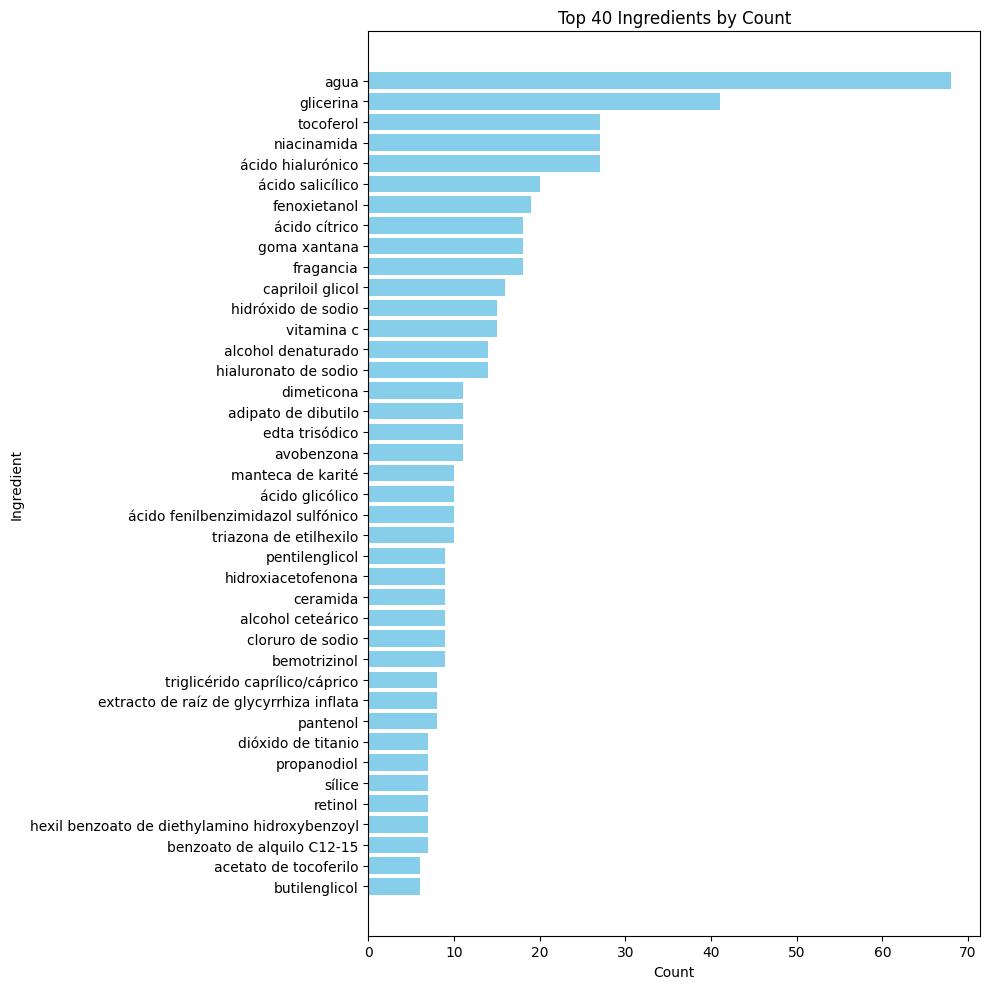

In [36]:
top_ingredients = new_ingredient_counts.most_common(40)

ingredients, counts = zip(*top_ingredients)

plt.figure(figsize=(10, 10))
plt.barh(ingredients, counts, color='skyblue')
plt.xlabel('Count')
plt.ylabel('Ingredient')
plt.title('Top 40 Ingredients by Count')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest count at the top
plt.tight_layout()
plt.show()

### 🐋 Alternativa deepseek
Tal vez hacer el mapping manualmente con chatgpt no es viable, en ese caso este código genera mappings en un archivo OUTPUT_FILE. Personalizar variables.

In [37]:
# OLLAMA_API_URL = "http://localhost:11434/api/generate"
# MODEL = "deepseek-r1:1.5b"  # From `ollama list`
# INPUT_FILE = "ingredients/unknown.txt"
# OUTPUT_FILE = "ingreds_clean_mapping.json"
# BATCH_SIZE = 50  # Adjust based on your system's memory

# # Read all ingredients from file
# with open(INPUT_FILE, "r", encoding="utf-8") as f:
#     dirty_ingredients = [line.strip() for line in f if line.strip()]

# # Initialize mapping
# ingredient_mapping = {}

# def clean_batch(batch):
#     """Envía un lote a Ollama para estandarizar."""
#     prompt = f"""
#     Eres un experto en cosmética. Procesa los siguientes términos y devuelve **solo los nombres técnicos** 
#     de ingredientes cosméticos en español y en minúsculas, **ignorando descripciones, puntuación o texto adicional**.
#     Los nombres pueden estar originalmente en inglés, pero los tienes que traducir al procesarlos.
    
#     Reglas:
#     1. Si el texto contiene '*', quedarte solo con lo que está después (ej: "reducir arrugas.*ácido hialurónico" → "ácido hialurónico").
#     2. Eliminar todo entre paréntesis o notas como "para piel seca".
#     3. Usar minúsculas y omitir puntuación final.
    
#     Formato de respuesta (JSON):
#     {{
#       "texto original": "nombre técnico limpio",
#       "ejemplo1.*ingrediente": "ingrediente",
#       "niacinamida (vitamina b3)": "niacinamida",
#       "neurosensina que calma las pieles sensibles": "neurosensina"
#     }}

#     Ingredientes a limpiar:
#     {json.dumps(batch, ensure_ascii=False)}
#     """
    
#     response = requests.post(
#         OLLAMA_API_URL,
#         json={
#             "model": MODEL,
#             "prompt": prompt,
#             "format": "json",
#             "stream": False,
#             "options": {"temperature": 0.0}  # Max consistency
#         }
#     )
    
#     if response.status_code == 200:
#         try:
#             return json.loads(response.json()["response"])
#         except json.JSONDecodeError:
#             print(f"⚠️ Batch failed (invalid JSON). Raw response:\n{response.json()['response']}")
#             return {}
#     else:
#         print(f"❌ API Error: {response.text}")
#         return {}

# # Process in batches
# for i in range(0, len(dirty_ingredients), BATCH_SIZE):
#     batch = dirty_ingredients[i:i+BATCH_SIZE]
#     print(f"Processing batch {i//BATCH_SIZE + 1}/{len(dirty_ingredients)//BATCH_SIZE + 1}...")
    
#     batch_mapping = clean_batch(batch)
#     ingredient_mapping.update(batch_mapping)
    
#     sleep(5)  # Rate limiting to avoid overwhelming Ollama

#     # Save progress after each batch (in case of crashes)
#     with open(OUTPUT_FILE, "w", encoding="utf-8") as f:
#         json.dump(ingredient_mapping, f, indent=4, ensure_ascii=False)

# print(f"\n✅ Successfully processed {len(ingredient_mapping)} ingredients. Saved to {OUTPUT_FILE}")

# # Final check for unmapped ingredients
# unmapped = set(dirty_ingredients) - set(ingredient_mapping.keys())
# if unmapped:
#     print(f"⚠️ {len(unmapped)} ingredients not mapped (using originals):")
#     for item in unmapped:
#         ingredient_mapping[item] = item

#     with open(OUTPUT_FILE, "w", encoding="utf-8") as f:
#         json.dump(ingredient_mapping, f, indent=4, ensure_ascii=False)